# Udacity Data Engineering Nanodegree Capstone Project

### Project Summary
This project provides a cleaned and wrangled dataset which can be used by data analysts and data scientists for their analysis. It combines information about transportation network providers, i.e. car sharing companies, with hourly wheather data and community area data from the city of Chicago. 

### Content
This notebook is separated into the following sections:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Import standard libraries
import pandas as pd 
from IPython.display import Image

In [2]:
# PySpark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, udf
from pyspark.sql.functions import hour, dayofmonth, dayofweek, weekofyear, month, year, date_trunc
from pyspark.sql.types import *

***
### Step 1: Scope the Project and Gather Data

#### 1.1 Scope
Over the last decade car sharing companies have become to taxis what AirBnB is to hotels. Their popularity has grown steadily and so did their market share of the local transportation industry. This projects aims at better understanding this mode of transportation by analyzing trips data from Chicago.

In a first step I will provide a dataset prone to answer questions like: How many trips do car sharing companies perform during a day/month/year? How much does the weather influence the number of trips and the prices charged (surge pricing)? What are highly frequented neighborhoods? 

From a technical perspective this project includes the entire ETL pipeline from data ingestion (**E**xtract), data modeling (**T**ransform) and data storage (**L**oad). My goal is to provide a ready-for-analysis dataset. 

<u>Beyond this project:</u>
In a second step we could compare these findings to [taxi trips data from Chicago](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew). 

#### 1.2 Describe and Gather Data
* *Trips Data* holds information about trips performed by car sharing companies in Chicago from 2018-2022. The city of Chicago provides data via their [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2018-2022-/m6dm-c72p). One row represents one trip. The entire dataset contains roughly 300M rows. For this project I will focus on one year worth of data. This will reduce the dataset to roughly 60M rows. 
* *Weather Data* contains basic hourly weather information, like temperature and precipitation. The data is provided by [Meteostat's Developer](https://dev.meteostat.net/) website from where it can be accessed via their API, by using a Python library or by downloading it in bulk. 
* *Community Data* 
  * The first dataset describes Chicago's 77 communities in terms of area and population. The information was downloaded from [Wikipedia](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) and is provided in the data folder as csv file.
  * The second dataset describes Chicago's 77 communities in terms of race, employment, income, education, health care, housing, and poverty (list not comprehensive). The dataset is provided by the [Heartland Alliance](https://www.heartlandalliance.org/heartland-alliance/research-and-policy/data-reports/chicago-data-dashboards/chicago-community-data-portal-chicago-well-being-indicators/) and can be accessed via a Tableau notebook or downloaded in bulk.

In this project I will focus on data from 2020. For the initial analysis (within this Jupyter Notebook) I will further reduce the data to a single day worth of records. 

In [3]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()
    return spark

In [4]:
spark = create_spark_session()

In [5]:
spark

**`trips data`**

In [6]:
# Uncomment for accessing data via the API 
#!get_trips.py

In [7]:
# Trips data provided as local files
# Focussing on one day for initial analysis 
trips_data = "data/trips_data/2020/1/trips_2020_1_1.json"
# Uncomment for entire dataset
# trips_datat = "data/trips_data/2020/*/*.json"

# Data schema
trips_schema = StructType([
    StructField("trip_id", StringType()),
    StructField("trip_start_timestamp", TimestampType()),
    StructField("trip_end_timestamp", TimestampType()),
    StructField("trip_seconds", StringType()),
    StructField("trip_miles", StringType()),
    StructField("pickup_census_tract", StringType()),
    StructField("dropoff_census_tract", StringType()),
    StructField("pickup_community_area", StringType()),
    StructField("dropoff_community_area", StringType()),
    StructField("fare", StringType()),
    StructField("tip", StringType()),
    StructField("additional_charges", StringType()),
    StructField("trip_total", StringType()),
    StructField("shared_trip_authorized", BooleanType()),
    StructField("trips_pooled", StringType()),
    StructField("pickup_centroid_latitude", StringType()),
    StructField("pickup_centroid_longitude", StringType()),
    StructField("pickup_centroid_location", StructType([
        StructField("type", StringType()), 
        StructField("coordinates", ArrayType(DoubleType(), True))
    ])),
    StructField("dropoff_centroid_latitude", StringType()),
    StructField("dropoff_centroid_longitude", StringType()),
    StructField("dropoff_centroid_location", StructType([
        StructField("type", StringType()), 
        StructField("coordinates", ArrayType(DoubleType(), True))
    ]))
])

In [8]:
# Read in trips data files
trips = spark.read.json(trips_data, schema=trips_schema, mode="PERMISSIVE", columnNameOfCorruptRecord="corrupt_record")

In [9]:
trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: string (nullable = true)
 |-- trip_miles: string (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: string (nullable = true)
 |-- pickup_community_area: string (nullable = true)
 |-- dropoff_community_area: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- tip: string (nullable = true)
 |-- additional_charges: string (nullable = true)
 |-- trip_total: string (nullable = true)
 |-- shared_trip_authorized: boolean (nullable = true)
 |-- trips_pooled: string (nullable = true)
 |-- pickup_centroid_latitude: string (nullable = true)
 |-- pickup_centroid_longitude: string (nullable = true)
 |-- pickup_centroid_location: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (c

In [10]:
trips.limit(20).toPandas()

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,additional_charges,trip_total,shared_trip_authorized,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,c4a636bddc6b0cc53d20b2cc5635ff5f0b4a8141,2020-01-01,2020-01-01 00:00:00,721,3.817277,None,17031980000,None,76,15,...,7.85,27.85,False,1,None,None,None,41.9790708201,-87.9030396611,"(Point, [-87.9030396611, 41.9790708201])"
1,000f3eb1fc6020bfb8a7daf0441589d314aac546,2020-01-01,2020-01-01 01:45:00,6399,88.99,None,17031231200,None,23,95,...,3.35,98.35,False,1,None,None,None,41.8990616211,-87.7213158985,"(Point, [-87.7213158985, 41.8990616211])"
2,8af67df7ca52185b15dc4fa29f2d972448fda731,2020-01-01,2020-01-01 00:15:00,1027,8.305581,None,None,15,77,12.5,...,2.55,15.05,False,1,41.9540276487,-87.7633990316,"(Point, [-87.7633990316, 41.9540276487])",41.9867117999,-87.6634164054,"(Point, [-87.6634164054, 41.9867117999])"
3,8be05cd4d7bf1997d306fc21dd4c37b9f9413558,2020-01-01,2020-01-01 00:00:00,384,2.013867,None,None,28,28,5,...,2.55,10.55,False,1,41.874005383,-87.6635175498,"(Point, [-87.6635175498, 41.874005383])",41.874005383,-87.6635175498,"(Point, [-87.6635175498, 41.874005383])"
4,8e7e77c3dd22422740402143aa88912521922ee2,2020-01-01,2020-01-01 00:15:00,553,2.45,None,None,9,10,7.5,...,2.55,13.05,False,1,42.0076125931,-87.8137810343,"(Point, [-87.8137810343, 42.0076125931])",41.9850151008,-87.8045320063,"(Point, [-87.8045320063, 41.9850151008])"
5,003454de9b0cb5a3d5a1723d40438f07b574749d,2020-01-01,2020-01-01 00:15:00,884,4.417869,17031010300,17031040402,1,4,10,...,2.55,13.55,False,1,42.0159343756,-87.6665362779,"(Point, [-87.6665362779, 42.0159343756])",41.9725625375,-87.6788459662,"(Point, [-87.6788459662, 41.9725625375])"
6,9343d1e5f13822780e7f8df61463401b90a576ab,2020-01-01,2020-01-01 00:30:00,1134,4.679628,None,None,30,30,10,...,2.55,12.55,False,1,41.8390869059,-87.714003807,"(Point, [-87.714003807, 41.8390869059])",41.8390869059,-87.714003807,"(Point, [-87.714003807, 41.8390869059])"
7,94314539302831a4a82eb35789f22644b006201b,2020-01-01,2020-01-01 00:45:00,2559,18.868672,None,None,20,43,17.5,...,2.55,20.05,True,2,41.9243470769,-87.7347397536,"(Point, [-87.7347397536, 41.9243470769])",41.7615779081,-87.5727819867,"(Point, [-87.5727819867, 41.7615779081])"
8,005827e8adc1c35df898021c18fb9fd3e4f1f5cb,2020-01-01,2020-01-01 00:15:00,977,12.35,None,None,32,None,17.5,...,2.55,20.05,False,1,41.8788655841,-87.6251921424,"(Point, [-87.6251921424, 41.8788655841])",None,None,None
9,005d727d45694054ff3502870af8826c255941a5,2020-01-01,2020-01-01 00:15:00,1205,11.646894,None,None,69,27,17.5,...,2.55,20.05,False,1,41.7632467988,-87.6161341112,"(Point, [-87.6161341112, 41.7632467988])",41.8789144956,-87.7058971305,"(Point, [-87.7058971305, 41.8789144956])"


In [11]:
trips.count()

304614

**`weather data`**

In [12]:
# Uncomment for accessing data via the API 
#!get_weather.py

In [13]:
# Read in csv file 
weather = pd.read_csv("data/weather_2020.csv")

In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 12 columns):
time    8784 non-null object
temp    8784 non-null float64
dwpt    8784 non-null float64
rhum    8784 non-null float64
prcp    8389 non-null float64
snow    0 non-null float64
wdir    8784 non-null float64
wspd    8784 non-null float64
wpgt    0 non-null float64
pres    8784 non-null float64
tsun    0 non-null float64
coco    8784 non-null float64
dtypes: float64(11), object(1)
memory usage: 823.6+ KB


In [15]:
# Weather data for a single day - 24 records
weather.head(24)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2020-01-01 00:00:00,-2.0,-6.0,74.0,NaN,NaN,280.0,24.0,NaN,1009.8,NaN,3.0
1,2020-01-01 01:00:00,-1.7,-6.1,72.0,0.0,NaN,280.0,24.1,NaN,1011.0,NaN,4.0
2,2020-01-01 02:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,20.5,NaN,1011.3,NaN,4.0
3,2020-01-01 03:00:00,-1.7,-5.5,75.0,0.0,NaN,260.0,27.7,NaN,1011.1,NaN,3.0
4,2020-01-01 04:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,14.8,NaN,1011.1,NaN,3.0
5,2020-01-01 05:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,27.7,NaN,1011.2,NaN,2.0
6,2020-01-01 06:00:00,-2.8,-5.6,81.0,0.0,NaN,260.0,13.0,NaN,1010.9,NaN,3.0
7,2020-01-01 07:00:00,-2.8,-5.6,81.0,0.0,NaN,260.0,14.8,NaN,1011.0,NaN,2.0
8,2020-01-01 08:00:00,-3.3,-6.1,81.0,0.0,NaN,270.0,13.0,NaN,1011.0,NaN,2.0
9,2020-01-01 09:00:00,-4.4,-6.7,84.0,0.0,NaN,250.0,13.0,NaN,1011.4,NaN,4.0


**`communities data`**

In [16]:
communities_df1 = pd.read_csv('data/areas.csv', sep='\t')

In [17]:
communities_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
No              78 non-null object
Name            78 non-null object
Population      78 non-null object
Areasqmi        78 non-null float64
Areakm          78 non-null float64
Densitysqmi2    78 non-null object
Densitykm2      78 non-null object
dtypes: float64(2), object(5)
memory usage: 4.3+ KB


In [18]:
communities_df1.head()

,No,Name,Population,Areasqmi,Areakm,Densitysqmi2,Densitykm2
0,01,Rogers Park,"55,628",1.84,4.77,"30,232.61","11,672.81"
1,02,West Ridge,"77,122",3.53,9.14,"21,847.59","8,435.36"
2,03,Uptown,"57,182",2.32,6.01,"24,647.41","9,516.37"
3,04,Lincoln Square,"40,494",2.56,6.63,"15,817.97","6,107.32"
4,05,North Center,"35,114",2.05,5.31,"17,128.78","6,613.42"


In [19]:
communities_df2 = pd.read_csv("data/communities_chicago.csv", encoding="utf-16", sep="\t")

In [20]:
communities_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50534 entries, 0 to 50533
Data columns (total 8 columns):
Geography            50534 non-null object
Grouping             50534 non-null object
Indicator            50534 non-null object
Landing              50534 non-null object
Years                50534 non-null object
Estimate             43938 non-null object
Number of Records    50534 non-null int64
Year                 50534 non-null int64
dtypes: int64(2), object(6)
memory usage: 3.1+ MB


In [21]:
communities_df2.head(10)

,Geography,Grouping,Indicator,Landing,Years,Estimate,Number of Records,Year
0,Albany Park,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"17,508827469",1,2014
1,Archer Heights,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"20,769622834",1,2014
2,Armour Square,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"29,145631068",1,2014
3,Ashburn,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"15,587171828",1,2014
4,Auburn Gresham,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"34,508683996",1,2014
5,Austin,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"36,003965672",1,2014
6,Avalon Park,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"25,832466181",1,2014
7,Avondale,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"12,713864307",1,2014
8,Belmont Cragin,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"21,175485911",1,2014
9,Beverly,Public benefits,SNAP Enrollment rate,HOMEPAGE,01.01.2014,"4,637257507",1,2014


***
### Step 2: Explore and Assess the Data

#### 2.1 Explore the Data

**`trips data`**

##### Wrong datatypes
* integer instead of string: trip_seconds, pickup_community_area, dropoff_community_area, trips_pooled
* double instead of string: trip_miles, fare, tip, additional_charges, trip_total, pickup_centroid_latitude, pickup_centroid_longitude, dropoff_centroid_latitude, dropoff_centroid_longitude
* Columns pickup_census_tract and dropoff_census_tract can remain strings. They represent a geographical id for a specific census area (like a zipcode).

##### Missing data
* No records only contain Null values.
* Almost 16,000 records do not contain a pickup location and roughly 24,500 records do not contain a dropoff location. In these cases trips either startet or ended outside of Chicago (see [dataset documentation](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2021/unf9-2zu4)). No record is missing both location data points. Either the pickup, dropoff or both locations are recorded. 
* 138 records do not contain a pickup community area, but a pickup location point. Latitude and longitude for these points are identical. They represent a default value which is applied if the pickup location is not recorded for privacy reasons (see [dataset documentation](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2021/unf9-2zu4)).

In [22]:
# Overview of Null values for each column
null_values = [trips.filter(isnull(x)).count() for x in trips.columns]

In [23]:
df_null_count = pd.DataFrame([null_values], columns=trips.columns)
df_null_count

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,additional_charges,trip_total,shared_trip_authorized,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,0,0,0,0,0,84497,90810,15911,24622,0,...,0,0,0,0,15773,15773,15773,24530,24530,24530


In [24]:
# Detailed view on missing data in location columns
df_null_pickup_area = trips.filter(isnull("pickup_community_area")).toPandas()

In [25]:
df_null_pickup_area.dropoff_community_area.value_counts().sort_values(ascending=False).head(20)

76    2360
8     1075
56     641
25     599
28     548
32     528
1      468
6      462
24     417
2      409
10     358
17     333
15     326
22     293
7      293
19     277
30     270
3      236
77     219
49     211
Name: dropoff_community_area, dtype: int64

In [26]:
# Assert either pickup or dropoff location is recorded
assert df_null_pickup_area.dropoff_community_area.isnull().any() == True

In [27]:
df_null_pickup_area[df_null_pickup_area.pickup_centroid_location.isnull() == False].head(10)

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,additional_charges,trip_total,shared_trip_authorized,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
111,06c6e02451608be351fd0c075b5f0f457639851f,2020-01-01 00:15:00,2020-01-01 00:45:00,1798,24.33,17031770700,17031842400,None,44,30,...,2.55,32.55,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.7424875717,-87.6300448953,"(Point, [-87.6300448953, 41.7424875717])"
130,1b8a8c9ee9204cf83ad1ead78ab7241b5b1d41a5,2020-01-01 00:15:00,2020-01-01 00:30:00,964,9.33,17031770700,17031831100,None,21,12.5,...,2.55,15.05,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.942859303,-87.717503858,"(Point, [-87.717503858, 41.942859303])"
218,729288b592b98597fa0a7404b6e161308b3dfc80,2020-01-01 00:15:00,2020-01-01 00:30:00,1652,13.26,17031770700,17031062500,None,6,15,...,2.55,21.55,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.9414882338,-87.671107656,"(Point, [-87.671107656, 41.9414882338])"
230,7e0246ef8a45b798891c406b1710a8acdd707812,2020-01-01 00:15:00,2020-01-01 00:15:00,10,2.25,17031770700,17031770700,None,None,2.5,...,7.55,10.05,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])"
257,8f55c09fcbc9c4848d63cb53981be498ed33b27d,2020-01-01 00:15:00,2020-01-01 00:45:00,1948,33.44,17031770700,17031031300,None,3,22.5,...,0,22.5,True,2,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.9729293173,-87.6502900743,"(Point, [-87.6502900743, 41.9729293173])"
657,20562357f04a9622a8a17fd2a915f169eccad150,2020-01-01 00:45:00,2020-01-01 01:15:00,1529,8.46,17031770700,17031110502,None,11,17.5,...,2.55,20.05,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.970288894,-87.759857019,"(Point, [-87.759857019, 41.970288894])"
784,8016302c8f596acb32ffbb6bcb0bd36b8f6dd9e1,2020-01-01 00:45:00,2020-01-01 01:00:00,1243,7.82,17031770700,17031140400,None,14,15,...,2.55,17.55,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.97153938,-87.7389372047,"(Point, [-87.7389372047, 41.97153938])"
844,a99b6c71329097fd30ef25d0a2dc6fcfb6daaae6,2020-01-01 00:45:00,2020-01-01 00:45:00,597,3.06,17031770700,17031090200,None,9,10,...,2.55,12.55,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",42.0056080233,-87.8130981301,"(Point, [-87.8130981301, 42.0056080233])"
857,b076fbd3914c9a77986a68cfe3d70012ecfe2aea,2020-01-01 00:45:00,2020-01-01 01:15:00,1397,15.3,17031770700,17031081700,None,8,25,...,2.55,27.55,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.8920421365,-87.6318639497,"(Point, [-87.6318639497, 41.8920421365])"
1013,2d868c184b732433fead0fed2681dfab55814907,2020-01-01 01:00:00,2020-01-01 01:30:00,1267,9.32,17031770700,17031151100,None,15,20,...,2.55,22.55,False,1,41.9827750091,-87.8773053996,"(Point, [-87.8773053996, 41.9827750091])",41.9422905548,-87.7617177214,"(Point, [-87.7617177214, 41.9422905548])"


In [28]:
# Default values for pickup location
df_null_pickup_area[df_null_pickup_area.pickup_centroid_location.isnull() == False].pickup_centroid_longitude.value_counts()

-87.8773053996    138
Name: pickup_centroid_longitude, dtype: int64

In [29]:
df_null_pickup_area[df_null_pickup_area.pickup_centroid_location.isnull() == False].pickup_centroid_latitude.value_counts()

41.9827750091    138
Name: pickup_centroid_latitude, dtype: int64

In [30]:
# Default values for dropoff location
df_null_dropoff_area = trips.filter(isnull("dropoff_community_area")).toPandas()
df_null_dropoff_area[df_null_dropoff_area.dropoff_centroid_location.isnull() == False].dropoff_centroid_longitude.value_counts()

-87.8773053996    92
Name: dropoff_centroid_longitude, dtype: int64

In [31]:
df_null_dropoff_area[df_null_dropoff_area.dropoff_centroid_location.isnull() == False].dropoff_centroid_latitude.value_counts()

41.9827750091    92
Name: dropoff_centroid_latitude, dtype: int64

##### Duplicated rows

In [32]:
df_duplicates = trips.groupby(trips.columns).count().filter(col("count") > 1)

In [33]:
df_duplicates.show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+-----+
|trip_id|trip_start_timestamp|trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area|fare|tip|additional_charges|trip_total|shared_trip_authorized|trips_pooled|pickup_centroid_latitude|pickup_centroid_longitude|pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|dropoff_centroid_location|count|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------

* No duplicate records found

**`weather data`**

##### Wrong datatypes
* timestamp instead of string: time
* integer instead of float: coco

##### Missing data
* no information in columns snow, wpgt and tsun - drop columns
* roughly 400 missing values in column prcp

##### Duplicated rows
* No duplicate records found

In [34]:
assert weather.duplicated().all() == 0

**`communities data`**

##### Wrong datatype
* communities_df1
  * integer instead of string: No
  * float instead of string: Densitysqmi2, Densitykm2
* communities_df2
  * float instead of string: Estimate

##### Missing data
* No missing data in the communities_df1 file
* One missing record in the communities_df2 file which seems logical looking at the remaining population percentages
* <u>Note:</u> For this project I focus on 2020 data and will only use a subset, i.e. some indicators, from the larger communities dataset. Which is why I will not assess missing values in other rows

In [35]:
communities_df1.isnull().any()

No              False
Name            False
Population      False
Areasqmi        False
Areakm          False
Densitysqmi2    False
Densitykm2      False
dtype: bool

In [36]:
communities_df2.isnull().any()

Geography            False
Grouping             False
Indicator            False
Landing              False
Years                False
Estimate              True
Number of Records    False
Year                 False
dtype: bool

In [37]:
# Focus on records with missing values in 2020
communities_df2_nulls = communities_df2[(communities_df2["Estimate"].isnull()) & (communities_df2["Year"] == 2020)]

In [38]:
communities_df2_nulls.Grouping.value_counts()

Employment                 1716
Academic outcomes           640
Income                      234
Small businesses            156
Housing                      87
Maternal & child health      78
Public safety                78
Health care access           26
School Effectiveness         12
School engagement             3
Race                          1
Name: Grouping, dtype: int64

In [39]:
communities_df2_nulls[communities_df2_nulls.Grouping == "Race"]

,Geography,Grouping,Indicator,Landing,Years,Estimate,Number of Records,Year
47618,Burnside,Race,"% Asian, 2020",HOMEPAGE,01.01.2020,NaN,1,2020


In [40]:
communities_df2[(communities_df2.Geography == "Burnside") & (communities_df2.Year == 2020) & (communities_df2.Grouping == "Race")]

,Geography,Grouping,Indicator,Landing,Years,Estimate,Number of Records,Year
47618,Burnside,Race,"% Asian, 2020",HOMEPAGE,01.01.2020,NaN,1,2020
47619,Burnside,Race,"% Black, 2020",HOMEPAGE,01.01.2020,"88,899082569",1,2020
47620,Burnside,Race,"% Latino, 2020",HOMEPAGE,01.01.2020,"7,155963303",1,2020
47621,Burnside,Race,"% White, 2020",HOMEPAGE,01.01.2020,"2,522935780",1,2020


##### Duplicated rows
* No duplicate records found

In [41]:
assert communities_df1.duplicated().all() == 0

In [42]:
assert communities_df2.duplicated().all() == 0

#### 2.2 Cleaning steps

**`trips data`**

In [43]:
# Copy trips to new dataframe
trips_cleaned = trips

In [44]:
trips_cleaned = trips_cleaned.withColumn("trip_seconds", trips_cleaned["trip_seconds"].cast(IntegerType())) \
    .withColumn("pickup_community_area", trips_cleaned["pickup_community_area"].cast(IntegerType())) \
    .withColumn("dropoff_community_area", trips_cleaned["dropoff_community_area"].cast(IntegerType())) \
    .withColumn("trips_pooled", trips_cleaned["trips_pooled"].cast(IntegerType())) \
    .withColumn("trip_miles", trips_cleaned["trip_miles"].cast(FloatType())) \
    .withColumn("fare", trips_cleaned["fare"].cast(FloatType())) \
    .withColumn("tip", trips_cleaned["tip"].cast(FloatType())) \
    .withColumn("additional_charges", trips_cleaned["additional_charges"].cast(FloatType())) \
    .withColumn("trip_total", trips_cleaned["trip_total"].cast(FloatType())) \
    .withColumn("pickup_centroid_latitude", trips_cleaned["pickup_centroid_latitude"].cast(DoubleType())) \
    .withColumn("pickup_centroid_longitude", trips_cleaned["pickup_centroid_longitude"].cast(DoubleType())) \
    .withColumn("dropoff_centroid_latitude", trips_cleaned["dropoff_centroid_latitude"].cast(DoubleType())) \
    .withColumn("dropoff_centroid_longitude", trips_cleaned["dropoff_centroid_longitude"].cast(DoubleType())) 

In [45]:
trips_cleaned.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: float (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: string (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: float (nullable = true)
 |-- tip: float (nullable = true)
 |-- additional_charges: float (nullable = true)
 |-- trip_total: float (nullable = true)
 |-- shared_trip_authorized: boolean (nullable = true)
 |-- trips_pooled: integer (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- pickup_centroid_location: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (co

**`weather data`**

In [46]:
weather.drop(["snow", "wpgt", "tsun"], axis=1, inplace=True)

In [47]:
weather.time = pd.to_datetime(weather.time)
weather.coco = weather.coco.astype(int)

In [48]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 9 columns):
time    8784 non-null datetime64[ns]
temp    8784 non-null float64
dwpt    8784 non-null float64
rhum    8784 non-null float64
prcp    8389 non-null float64
wdir    8784 non-null float64
wspd    8784 non-null float64
pres    8784 non-null float64
coco    8784 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 617.7 KB


**`communities data`**

In [49]:
# Dropping the last row 'Total'
communities_df1.drop(communities_df1[communities_df1["No"] == "Total"].index[0], inplace=True)

In [50]:
communities_df1.tail()

,No,Name,Population,Areasqmi,Areakm,Densitysqmi2,Densitykm2
72,73,Washington Heights,"25,065",2.86,7.41,"8,763.99","3,383.78"
73,74,Mount Greenwood,"18,628",2.71,7.02,"6,873.8","2,653.97"
74,75,Morgan Park,"21,186",3.30,8.55,"6,420","2,478.76"
75,76,O'Hare,"13,418",13.34,34.55,"1,005.85",388.36
76,77,Edgewater,"56,296",1.74,4.51,"32,354.02","12,491.89"


In [51]:
# Removing the comma separating thousands
communities_df1["Population"] = [float(str(i).replace(",", "")) for i in communities_df1["Population"]]
communities_df1["Densitysqmi2"] = [float(str(i).replace(",", "")) for i in communities_df1["Densitysqmi2"]]
communities_df1["Densitykm2"] = [float(str(i).replace(",", "")) for i in communities_df1["Densitykm2"]]

In [52]:
# Changing the datatypes
communities_df1["No"] = communities_df1["No"].astype(int)
communities_df1["Densitysqmi2"] = communities_df1["Densitysqmi2"].astype(float)
communities_df1["Densitykm2"] = communities_df1["Densitykm2"].astype(float)

In [53]:
communities_df1.head()

,No,Name,Population,Areasqmi,Areakm,Densitysqmi2,Densitykm2
0,1,Rogers Park,55628.0,1.84,4.77,30232.61,11672.81
1,2,West Ridge,77122.0,3.53,9.14,21847.59,8435.36
2,3,Uptown,57182.0,2.32,6.01,24647.41,9516.37
3,4,Lincoln Square,40494.0,2.56,6.63,15817.97,6107.32
4,5,North Center,35114.0,2.05,5.31,17128.78,6613.42


In [54]:
communities_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 7 columns):
No              77 non-null int64
Name            77 non-null object
Population      77 non-null float64
Areasqmi        77 non-null float64
Areakm          77 non-null float64
Densitysqmi2    77 non-null float64
Densitykm2      77 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 4.8+ KB


In [55]:
# Replacing the comma with a dot
communities_df2["Estimate"] = [float(str(i).replace(",", ".")) for i in communities_df2["Estimate"]]

In [56]:
communities_df2["Estimate"] = communities_df2["Estimate"].astype(float)

In [57]:
communities_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50534 entries, 0 to 50533
Data columns (total 8 columns):
Geography            50534 non-null object
Grouping             50534 non-null object
Indicator            50534 non-null object
Landing              50534 non-null object
Years                50534 non-null object
Estimate             43938 non-null float64
Number of Records    50534 non-null int64
Year                 50534 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.1+ MB


***
### Step 3: Define the Data Model

#### 3.1 Conceptual Data Model

I have decided to design a star schema data model. Information is separated into dimension and fact tables. This set up is ideal to do aggregations and analytics. When adding taxi trip data in a second step, the same dimension tables can be used. 

**DATA DICTIONARY**

*Dimension tables*
* weather 
  * hour - hour of the day
  * temp - hourly average temperature 
  * rain - hourly average rain fall
  * wind_speed - hourly average wind speed
  * condition_code - hourly weather condition code 
    1 - Clear, 2 - Fair, 3 - Cloudy, 4 - Overcast, 5 - Fog
    6 - Freezing Fog, 7 - Light Rain, 8 - Rain, 9 - Heavy Rain, 10 - Freezing Rain
    11 - Heavy Freezing Rain, 12 - Sleet, 13 - Heavy Sleet, 14 - Light Snowfall, 15 - Snowfall
    16 - Heavy Snowfall, 17 - Rain Shower, 18 - Heavy Rain Shower, 19 - Sleet Shower, 20 - Heavy Sleet Shower
    21 - Snow Shower, 22 - Heavy Snow Shower, 23 - Lightning, 24 - Hail, 25 - Thunderstorm
    26 - Heavy Thunderstorm, 27 - Storm
* communities 
  * id - unique identifier of one of Chicago's 77 community areas
  * name - community area name
  * population - community area population (2020)
  * area - community area size in square kilometers
  * density - community area density [population/km2]
  * asian_perc - percentage of Asian population
  * black_perc - percentage of Black population
  * white_perc - percentage of White population
  * latino_perc - percentage of Latino population
  * poverty_perc - percentage of people living below the poverty line
  * ext_poverty_perc - percentage of people living in extreme poverty
* time 
  * trip_time - any recorded start or end time
  * year - extracted year
  * month - extracted month
  * day - extracted day
  * dayofweek - extracted day of the week
  * rounded_hour - trip_time rounded to preceding hour (e.g. 07:15:00, 07:30:00, 07:45:00 all rounded to 07:00:00) 

*Fact tables*
* trips (partitioned by year and month)
  * trip_id - unique identifier of a single trip
  * trip_start_time - when the trip started, rounded to nearest 15 min
  * trip_end_time - when the trip ended, rounded to nearest 15 min
  * year - year, the trip occurred
  * month - month, the trip occurred
  * trip_seconds - trip duration in seconds
  * trip_miles - trip distance in miles
  * pickup_area - community area where the trip started
  * dropoff_area - community area where the trip ended
  * fare - trip cost, rounded to nearest USD 2,50
  * tip - trip tip, rounded to nearest USD 1,00 (cash tips not recorded)
  * additional_charges - taxes, fees, or any other charges
  * trip_total - fare, tip, and additional charges added up
  * shared_trip_authorized - whether the customer agreed to a shared trip 
  * trips_pooled - if customers were matched, how many trips were pooled (including this one), each shared trip will have a separate record
* trips_mapping (partitioned by pickup_area)
  * trip_id - unique identifier of a single trip
  * pickup_area - community area where the trip started
  * dropoff_area - community area where the trip ended
  * pickup_lat - latitude of the starting point, nearest census area
  * pickup_long - longitude of the starting point, nearest census area
  * dropoff_lat - latitude of the end point, nearest census area
  * dropoff_long - longitude of the end point, nearest census area

The second fact table is provided for mapping purposes.

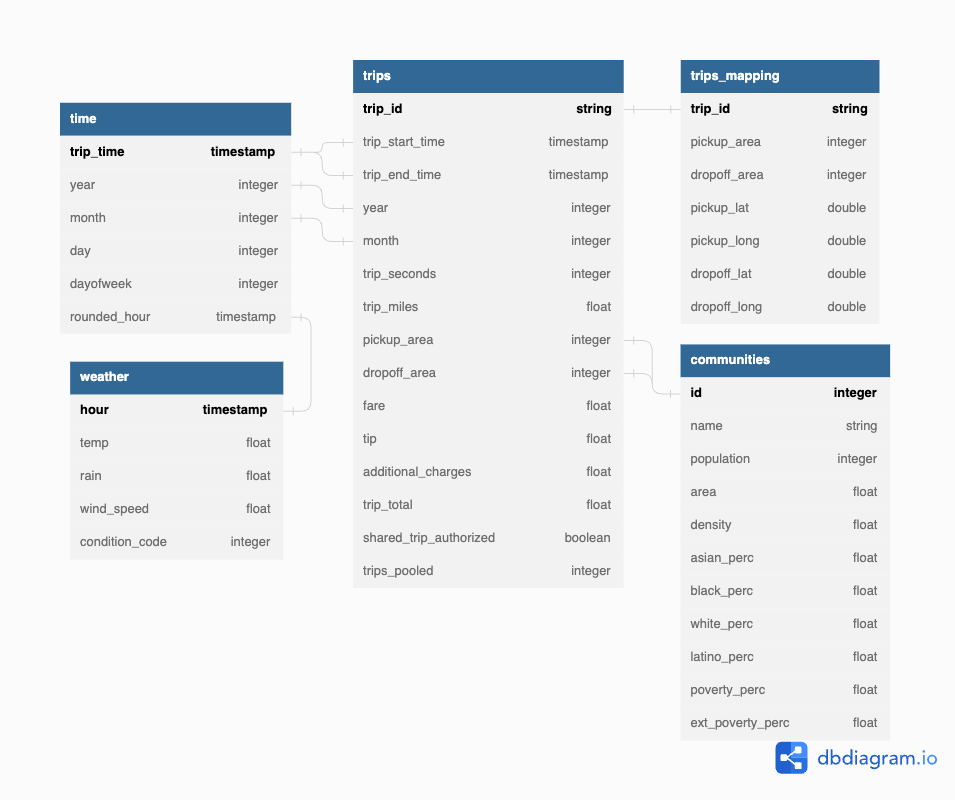

In [58]:
fig = Image(filename="images/trips_db_schema.png")
fig

#### 3.2 Mapping out Data Pipelines

1. Extract data from trips API by running get_trips.py
2. Extract data from weather API by running get_weather.py
3. Load data into PySpark dataframe (trips data) - due to the size of this dataset Spark is used for handling
4. Load data into Pandas dataframe (weather data, community datasets)
5. Transform all four dataframes 
6. Save cleaned dimension tables as csv files and cleaned fact tables as parquet files

***
### Step 4: Run Pipelines to Model the Data 

#### 4.1 Create the data model

* Install pre-requesites
  * [PySpark](https://pypi.org/project/pyspark/)
  * [sodapy](https://pypi.org/project/sodapy/)
  * [meteostat](https://pypi.org/project/meteostat/)
  * [pandas](https://pypi.org/project/pandas/)
* Run python scripts

```
python data/get_trips.py
python data/get_weather.py
python etl.py
```

* Exemplary database querying

```
python test_queries.py
```

**`trips table`**

In [59]:
trips_cleaned = trips_cleaned.withColumn("year", year(col("trip_start_timestamp"))) \
                            .withColumn("month", month(col("trip_start_timestamp")))

In [60]:
trips_table = trips_cleaned.select("trip_id", "trip_start_timestamp", "trip_end_timestamp", "year", "month", "pickup_community_area", "dropoff_community_area", "trip_seconds", "trip_miles", "fare", "tip", "additional_charges", "trip_total", "shared_trip_authorized", "trips_pooled") \
                .withColumnRenamed("trip_start_timestamp", "trip_start_time") \
                .withColumnRenamed("trip_end_timestamp", "trip_end_time") \
                .withColumnRenamed("pickup_community_area", "pickup_area") \
                .withColumnRenamed("dropoff_community_area", "dropoff_area")

In [61]:
trips_table.write.partitionBy("year", "month").mode("overwrite").parquet("data/trips_cleaned/")

**`trips mapping table`**

In [62]:
trips_mapping_table = trips_cleaned \
                        .select("trip_id", "pickup_community_area", "dropoff_community_area", "pickup_centroid_latitude", "pickup_centroid_longitude", "dropoff_centroid_latitude", "dropoff_centroid_longitude") \
                        .withColumnRenamed("pickup_community_area", "pickup_area") \
                        .withColumnRenamed("dropoff_community_area", "dropoff_area") \
                        .withColumnRenamed("pickup_centroid_latitude", "pickup_lat") \
                        .withColumnRenamed("pickup_centroid_longitude", "pickup_long") \
                        .withColumnRenamed("dropoff_centroid_latitude", "dropoff_lat") \
                        .withColumnRenamed("dropoff_centroid_longitude", "dropoff_long")

In [63]:
trips_mapping_table.write.partitionBy("pickup_area").mode("overwrite").parquet("data/trips_mapping/")

**`time table`**

In [64]:
trips_cleaned = trips_cleaned.withColumn("day", dayofmonth(col("trip_start_timestamp"))) \
                        .withColumn("dayofweek", dayofweek(col("trip_start_timestamp"))) \

In [65]:
time_table = trips_cleaned.select("trip_start_timestamp", "year", "month", "day", "dayofweek", date_trunc("hour", col("trip_start_timestamp")).alias("rounded_hour")) \
                    .withColumnRenamed("trip_start_timestamp", "trip_time")

In [66]:
time_table.write.mode("overwrite").parquet("data/time")

**`weather table`**

In [67]:
weather_table = weather[["time", "temp", "prcp", "wspd", "coco"]] \
                    .rename(columns={"time": "hour", "prcp": "rain", "wspd": "wind_speed", "coco": "condition_code"})

In [68]:
weather_table.to_csv("data/weather_cleaned.csv")

**`communities table`**

In [69]:
df1 = communities_df1[["No", "Name", "Population", "Areakm", "Densitykm2"]]

In [70]:
df1 = df1.rename(columns={"No": "id", "Name": "name", "Population": "population", "Areakm": "area", "Densitykm2": "density"})

In [71]:
df1.head()

,id,name,population,area,density
0,1,Rogers Park,55628.0,4.77,11672.81
1,2,West Ridge,77122.0,9.14,8435.36
2,3,Uptown,57182.0,6.01,9516.37
3,4,Lincoln Square,40494.0,6.63,6107.32
4,5,North Center,35114.0,5.31,6613.42


In [72]:
df2 = communities_df2[(communities_df2.Year == 2020) & ((communities_df2.Grouping == "Race") | (communities_df2.Grouping == "Poverty"))]

In [73]:
df2 = df2[["Geography", "Grouping", "Indicator", "Estimate"]]

In [74]:
df2.Geography.unique()

array(['Albany Park', 'Archer Heights', 'Armour Square', 'Ashburn',
       'Auburn Gresham', 'Austin', 'Avalon Park', 'Avondale',
       'Belmont Cragin', 'Beverly', 'Bridgeport', 'Brighton Park',
       'Burnside', 'Calumet Heights', 'Chatham', 'Chicago Lawn',
       'Chicago Overall', 'Clearing', 'Douglas', 'Dunning',
       'East Garfield Park', 'East Side', 'Edgewater', 'Edison Park',
       'Englewood', 'Forest Glen', 'Fuller Park', 'Gage Park',
       'Garfield Ridge', 'Grand Boulevard', 'Greater Grand Crossing',
       'Hegewisch', 'Hermosa', 'Humboldt Park', 'Hyde Park', 'Irving Park',
       'Jefferson Park', 'Kenwood', 'Lake View', 'Lincoln Park',
       'Lincoln Square', 'Logan Square', 'Loop', 'Lower West Side',
       'Mckinley Park', 'Montclare', 'Morgan Park', 'Mount Greenwood',
       'Near North Side', 'Near South Side', 'Near West Side', 'New City',
       'North Center', 'North Lawndale', 'North Park', 'Norwood Park',
       'Oakland', 'Ohare', 'Portage Park', 'Pullm

In [75]:
df2.Geography.nunique()

78

In [76]:
# Drop Chicago's overall data
df2.drop(df2[df2["Geography"] == "Chicago Overall"].index, inplace=True)

In [77]:
df2.Geography.nunique()

77

In [78]:
# Transpose rows and columns to match communities_df1 table format
df2 = df2.pivot(index="Geography", columns="Indicator", values="Estimate").reset_index()

In [79]:
df2.drop(["Child poverty rate, 2020"], axis=1, inplace=True)

In [80]:
df2 = df2.rename(columns={"Geography": "name", "% Asian, 2020": "asian_perc", "% Black, 2020": "black_perc", "% White, 2020": "white_perc", "% Latino, 2020": "latino_perc", "% in poverty, 2020": "poverty_perc", "% in extreme poverty, 2020": "ext_poverty_perc"})

In [81]:
df2.head()

Indicator,name,asian_perc,black_perc,latino_perc,white_perc,ext_poverty_perc,poverty_perc
0,Albany Park,12.561701,5.101858,45.909667,33.716042,5.029020,13.403222
1,Archer Heights,4.508719,0.768925,79.856295,14.675588,2.120649,10.978487
2,Armour Square,70.792901,8.608879,5.655748,14.088482,8.197424,28.045378
3,Ashburn,0.826897,45.099653,42.692696,10.037052,5.361839,13.458193
4,Auburn Gresham,0.265253,94.553135,2.984118,1.045739,13.573896,25.086572


In [82]:
communities_table = df1.merge(df2, on="name", how="outer")

In [83]:
communities_table.tail()

,id,name,population,area,density,asian_perc,black_perc,latino_perc,white_perc,ext_poverty_perc,poverty_perc
75,76.0,O'Hare,13418.0,34.55,388.36,NaN,NaN,NaN,NaN,NaN,NaN
76,77.0,Edgewater,56296.0,4.51,12491.89,13.723886,13.259863,15.888678,53.517506,6.296314,14.827754
77,NaN,Loop,NaN,NaN,NaN,21.387540,6.984161,9.427044,58.903151,7.049348,9.441162
78,NaN,Mckinley Park,NaN,NaN,NaN,29.915527,1.224707,52.796122,15.418545,3.936055,12.983297
79,NaN,Ohare,NaN,NaN,NaN,14.992129,6.252501,10.648032,66.007734,4.036482,10.914541


In [84]:
communities_table[communities_table.population.isnull()]

,id,name,population,area,density,asian_perc,black_perc,latino_perc,white_perc,ext_poverty_perc,poverty_perc
77,NaN,Loop,NaN,NaN,NaN,21.387540,6.984161,9.427044,58.903151,7.049348,9.441162
78,NaN,Mckinley Park,NaN,NaN,NaN,29.915527,1.224707,52.796122,15.418545,3.936055,12.983297
79,NaN,Ohare,NaN,NaN,NaN,14.992129,6.252501,10.648032,66.007734,4.036482,10.914541


In [85]:
communities_table[communities_table.black_perc.isnull()]

,id,name,population,area,density,asian_perc,black_perc,latino_perc,white_perc,ext_poverty_perc,poverty_perc
31,32.0,(The) Loop[11],42298.0,4.27,9897.73,NaN,NaN,NaN,NaN,NaN,NaN
58,59.0,McKinley Park,15923.0,3.65,4360.19,NaN,NaN,NaN,NaN,NaN,NaN
75,76.0,O'Hare,13418.0,34.55,388.36,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df1.loc[df1[df1.name == "(The) Loop[11]"].index, "name"] = "Loop"

In [87]:
df1.loc[df1[df1.name == "McKinley Park"].index, "name"] = "Mckinley Park"

In [88]:
df1.loc[df1[df1.name == "O'Hare"].index, "name"] = "Ohare"

In [89]:
# Merge both dataframes again
communities_table = df1.merge(df2, on="name", how="outer")

In [90]:
communities_table.tail()

,id,name,population,area,density,asian_perc,black_perc,latino_perc,white_perc,ext_poverty_perc,poverty_perc
72,73,Washington Heights,25065.0,7.41,3383.78,0.175347,95.410104,1.466080,1.734258,9.836981,20.031366
73,74,Mount Greenwood,18628.0,7.02,2653.97,1.608280,3.232484,10.483015,81.141189,3.422513,4.554194
74,75,Morgan Park,21186.0,8.55,2478.76,0.445587,60.352873,4.984935,30.926756,6.922185,11.580160
75,76,Ohare,13418.0,34.55,388.36,14.992129,6.252501,10.648032,66.007734,4.036482,10.914541
76,77,Edgewater,56296.0,4.51,12491.89,13.723886,13.259863,15.888678,53.517506,6.296314,14.827754


In [91]:
communities_table.to_csv("data/communities_cleaned.csv")

#### 4.2 Data Quality Checks

##### Tables must exist

In [191]:
def table_exists(df):
    if df is not None:
        return True
    else:
        return False

In [196]:
# Three dimension tables and two fact tables expected to exist
try: 
    assert table_exists(trips_table)
    assert table_exists(trips_mapping_table)
    assert table_exists(communities_table)
    assert table_exists(weather_table)
    assert table_exists(time_table)
    print("Data Quality check passed.")
except Exception as e:
    print("Data Quality check failed. Missing table")
    print(e)

Data Quality check passed.


##### Tables must contain data

In [197]:
# Three dimension tables and two fact tables expected to hold records
try: 
    assert trips_table.count() > 0
    assert trips_mapping_table.count() > 0
    assert communities_table.count().all() > 0
    assert weather_table.count().all() > 0
    assert time_table.count() > 0
    print("Data Quality check passed.")
except Exception as e:
    print("Data Quality check failed. Missing data")
    print(e)

Data Quality check passed.


##### Number of community areas should be 77

In [142]:
try:
    assert communities_table.name.nunique() == 77
    print("Data Quality check passed.")
except Exception as e:
    print("Data quality check failed. Incorrect number of community areas")
    print(e)

Data Quality check passed.


***
### 5. Complete Project Write Up

Since the entire dataset comprises more than 50 million records, I decided to utilize PySpark's power of handling datasets that are too big for local memory storage. For the smaller datasets Pandas is sufficient.

A large portion of this data model is extracted from an open API. Loading a year worth of data for the initial analysis is time consuming. Some API even limit the number of requests you can make from a single IP adress. Therefore I recommend updating trips data weekly or monthly. The data analyst or data scientist could consider only loading the latest week or month and compare this information to aggregated data from previous timeframes. 

Scenarios to consider:
 * The data was increased by 100x.
    * Input and output data stored in cloud, like AWS S3
    * Make use of more EC2 instances and increase the number of Spark worker nodes
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
    * The pipeline should be automated with a tool like Apache Airflow. It also might make sense to reconsider the data required to fill the dashboard. A separate analytics table partitioned efficiently could increase the processing speed.
 * The database needed to be accessed by 100+ people.
    * Find out what these users needs are: analytics, atomic data, aggregations, or the like. Build a cloud based data warehouse and specific data cubes for particular user segments. Furthermore it should be considered to integrate a specific BI tool for non-technical users.